In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
#device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device = t.device('cpu')

In [3]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    batch_size, batch_height, batch_width = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    nbh_coords[nbh_coords == -1] = 1
    nbh_coords[nbh_coords == batch_height] = batch_height -2
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [4]:
STEP_SIZES = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)

def MCS(batch, target_vol, temperature):
    batch_size, batch_height, batch_width = batch.shape
    frontiers = get_moore_nbh(batch)
    
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    step_sizes = t.vstack(random.choices(STEP_SIZES, k=batch_src_coords.shape[0]))
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    #print(src_i, src_j, src_k)
    #print(tgt_i, tgt_j, tgt_k)
    
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    #print(current_volumes)
    #print(vol_changes)
    #print(adjusted_vols)
    
    unequal_mask = batch[tgt_i, tgt_j, tgt_k] != batch[src_i, src_j, src_k]
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0
    vol_change_negative_mask = vol_changes < 0
    
    auto_upd_mask = t.logical_and(
        vol_change_negative_mask,
        greater_zero_mask
    )
    
    #print(auto_upd_mask)
    
    auto_upd_i = tgt_i[auto_upd_mask]
    auto_upd_j = tgt_j[auto_upd_mask]
    auto_upd_k = tgt_k[auto_upd_mask]
    
    batch[auto_upd_i, auto_upd_j, auto_upd_k] += vol_changes[auto_upd_mask]
    
     
    update_mask = t.logical_and(
        vol_change_positive_mask,
        t.logical_and(
            greater_zero_mask,
            t.logical_and(unequal_mask, sml_eq_two_mask)
        )
    )
    
    #print(update_mask)
    
    #print(vol_changes[update_mask])
    #print(adjusted_vols[update_mask])
    #print(f"delta h {-((target_vol - adjusted_vols[update_mask]) ** 2)}")
    update_probabilities = t.exp(-((target_vol - adjusted_vols[update_mask]) ** 2) / temperature)
    #print(f"prob: {update_probabilities}")
    logits = t.cat((update_probabilities.unsqueeze(0), (1-update_probabilities).unsqueeze(0))).T
    #print(f"logits: {logits}")
    one_hot = t.nn.functional.gumbel_softmax(t.log(logits), hard=True)
    #print(one_hot)
    upd_vals = one_hot[:,0] * vol_changes[update_mask]
    
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    
    #print(upd_i, upd_j, upd_k)
    
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [5]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float, num_steps:int):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    grad = t.autograd.grad(mean_distance, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance

In [6]:
def create_dist_matrix(batch:t.Tensor):
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

# Visualize sample sim

In [41]:
temperature = 27.
target_vol = 1.
batch = t.zeros(1,8,8, device=device)
batch[:,4,4] += 1

states = []
for i in tqdm(range(10000)):
    batch = MCS(batch, target_vol, temperature)
    if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
        print("ISSUE DETECTED, STOP SIM")
        break
    else:
        states.append(batch[0].detach().clone().cpu().numpy())

imgs = [Image.fromarray((1-state)*255) for state in states]
print(len(imgs))
imgs[0].save("test.gif", save_all=True, append_images=imgs[1:], fps=60)

100%|██████████| 10000/10000 [00:10<00:00, 969.87it/s]


10000


# Num_steps = 40, 8x8 grid

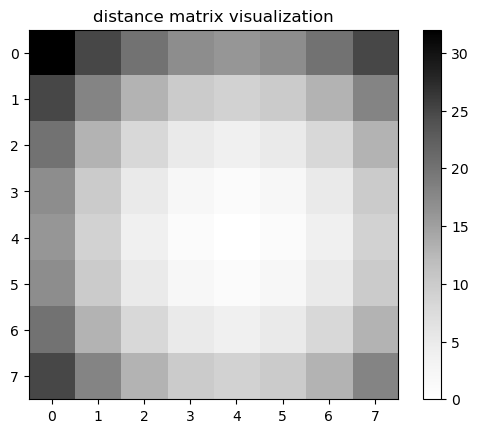

In [7]:
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, 8x8 grid

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)

grads_v0 = []
mean_distances_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())

target_vol = 1, 8x8 grid

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)

grads_v1 = []
mean_distances_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())

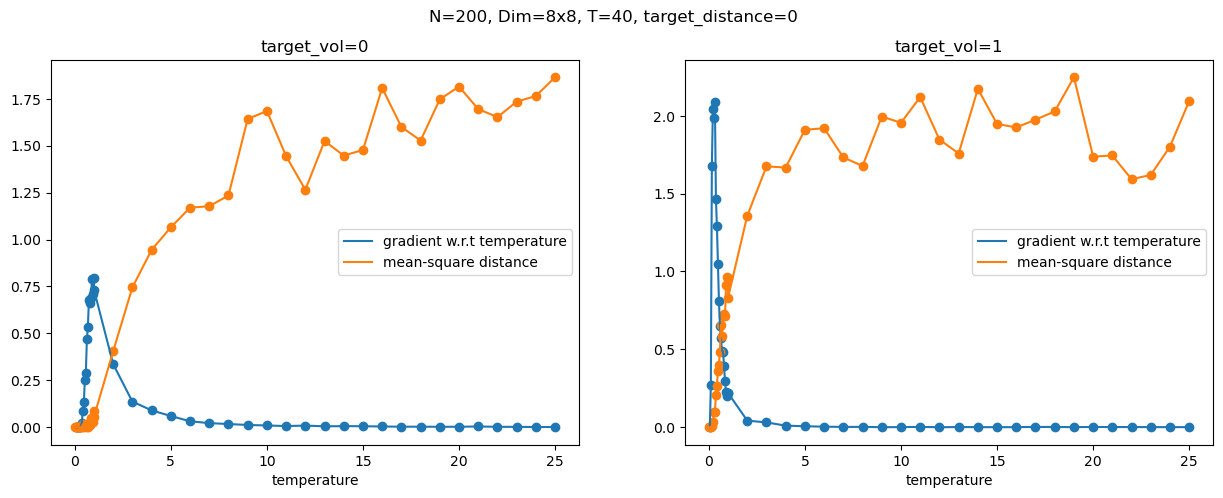

In [11]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].set(title="target_vol=1", xlabel="temperature")
axs[1].legend()

fig.suptitle("N=200, Dim=8x8, T=40, target_distance=0")
plt.show()


# Introduce Squared loss to target distance

In [12]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float, num_steps:int, target_distance:float):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}")
    loss = (mean_distance - target_distance)**2
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance, loss

## Num_steps = 40, 8x8 grid

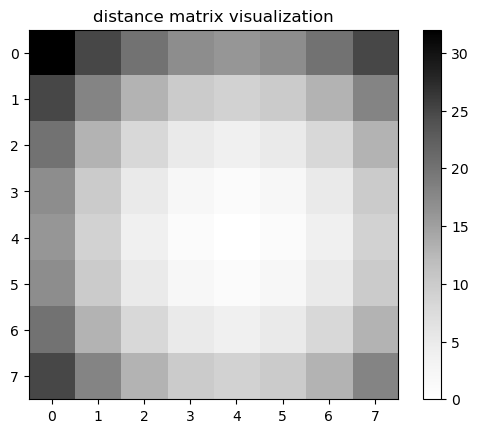

In [13]:
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, target_dist = 0

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

target_vol = 1, target_dist = 0

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

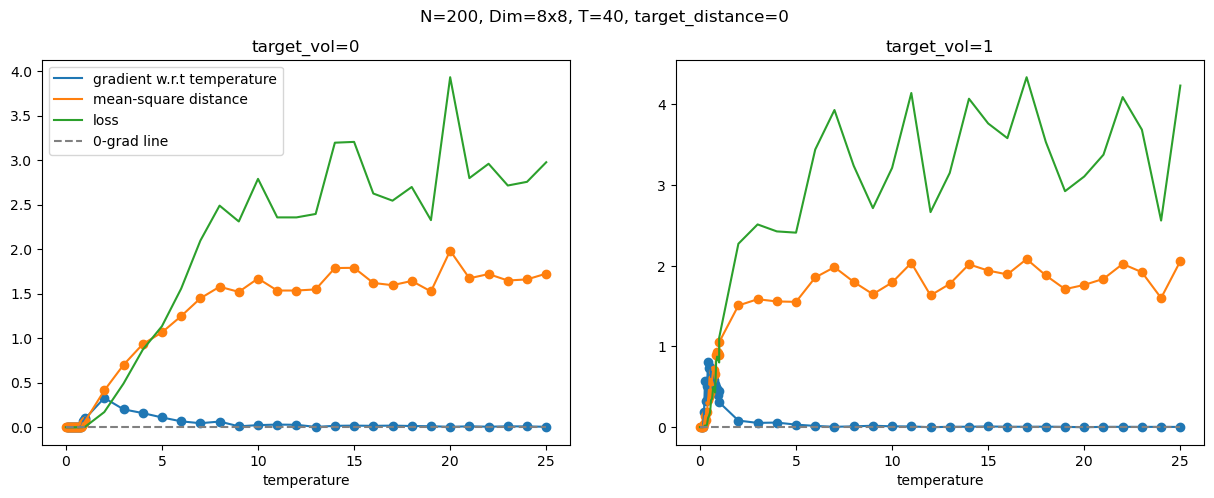

In [17]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=200, Dim=8x8, T=40, target_distance=0")
plt.show()


target_vol = 0, target_dist = 0.2

In [18]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.2

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

100%|██████████| 40/40 [00:01<00:00, 29.93it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 40/40 [00:01<00:00, 30.52it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: -3.9579945778175604e-29


100%|██████████| 40/40 [00:01<00:00, 26.63it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: -2.0835136187950104e-13


100%|██████████| 40/40 [00:01<00:00, 30.66it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: -3.1015982671078746e-08


100%|██████████| 40/40 [00:01<00:00, 27.10it/s]


temperature: 0.21052631735801697, mean distance: 0.0
gradient: -7.205715064628748e-06


100%|██████████| 40/40 [00:01<00:00, 30.45it/s]


temperature: 0.2631579041481018, mean distance: 0.0
gradient: -0.00020753280841745436


100%|██████████| 40/40 [00:01<00:00, 30.43it/s]


temperature: 0.31578946113586426, mean distance: 0.0
gradient: -0.0017569680931046605


100%|██████████| 40/40 [00:01<00:00, 27.19it/s]


temperature: 0.3684210479259491, mean distance: 0.0
gradient: -0.01014229841530323


100%|██████████| 40/40 [00:01<00:00, 27.97it/s]


temperature: 0.42105263471603394, mean distance: 0.0
gradient: -0.026942847296595573


100%|██████████| 40/40 [00:01<00:00, 30.09it/s]


temperature: 0.4736842215061188, mean distance: 0.0
gradient: -0.053843822330236435


100%|██████████| 40/40 [00:01<00:00, 29.73it/s]


temperature: 0.5263158082962036, mean distance: 0.0
gradient: -0.12624642252922058


100%|██████████| 40/40 [00:01<00:00, 28.49it/s]


temperature: 0.5789473652839661, mean distance: 0.0
gradient: -0.17199651896953583


100%|██████████| 40/40 [00:01<00:00, 28.61it/s]


temperature: 0.6315789222717285, mean distance: 0.015000000000000003
gradient: -0.15764182806015015


100%|██████████| 40/40 [00:01<00:00, 30.48it/s]


temperature: 0.6842105388641357, mean distance: 0.010000000000000002
gradient: -0.2240752875804901


100%|██████████| 40/40 [00:01<00:00, 30.04it/s]


temperature: 0.7368420958518982, mean distance: 0.005000000000000001
gradient: -0.20511215925216675


100%|██████████| 40/40 [00:01<00:00, 30.99it/s]


temperature: 0.7894736528396606, mean distance: 0.025000000000000005
gradient: -0.21974366903305054


100%|██████████| 40/40 [00:01<00:00, 30.29it/s]


temperature: 0.8421052694320679, mean distance: 0.020000000000000004
gradient: -0.23951789736747742


100%|██████████| 40/40 [00:01<00:00, 27.85it/s]


temperature: 0.8947368264198303, mean distance: 0.022500000000000006
gradient: -0.252993106842041


100%|██████████| 40/40 [00:01<00:00, 30.99it/s]


temperature: 0.9473684430122375, mean distance: 0.08500000000000002
gradient: -0.17762932181358337


100%|██████████| 40/40 [00:01<00:00, 28.32it/s]


temperature: 1.0, mean distance: 0.125
gradient: -0.09931980073451996


100%|██████████| 40/40 [00:01<00:00, 30.22it/s]


temperature: 1.0, mean distance: 0.045
gradient: -0.22313764691352844


100%|██████████| 40/40 [00:01<00:00, 30.11it/s]


temperature: 2.0, mean distance: 0.3575
gradient: 0.1210712194442749


100%|██████████| 40/40 [00:01<00:00, 29.15it/s]


temperature: 3.0, mean distance: 0.78
gradient: 0.17620185017585754


100%|██████████| 40/40 [00:01<00:00, 28.81it/s]


temperature: 4.0, mean distance: 1.0175
gradient: 0.11850439012050629


100%|██████████| 40/40 [00:01<00:00, 28.49it/s]


temperature: 5.0, mean distance: 1.1625
gradient: 0.10622155666351318


100%|██████████| 40/40 [00:01<00:00, 28.75it/s]


temperature: 6.0, mean distance: 1.1675
gradient: 0.07697610557079315


100%|██████████| 40/40 [00:01<00:00, 28.38it/s]


temperature: 7.0, mean distance: 1.41
gradient: 0.03532988205552101


100%|██████████| 40/40 [00:01<00:00, 28.15it/s]


temperature: 8.0, mean distance: 1.4475
gradient: 0.04126168414950371


100%|██████████| 40/40 [00:01<00:00, 26.92it/s]


temperature: 9.0, mean distance: 1.7075
gradient: 0.026445912197232246


100%|██████████| 40/40 [00:01<00:00, 26.68it/s]


temperature: 10.0, mean distance: 1.525
gradient: 0.0143964858725667


100%|██████████| 40/40 [00:01<00:00, 28.53it/s]


temperature: 11.0, mean distance: 1.58
gradient: 0.019421899691224098


100%|██████████| 40/40 [00:01<00:00, 28.92it/s]


temperature: 12.0, mean distance: 1.305
gradient: 0.014529893174767494


100%|██████████| 40/40 [00:01<00:00, 28.28it/s]


temperature: 13.0, mean distance: 1.72
gradient: 0.018543345853686333


100%|██████████| 40/40 [00:01<00:00, 28.09it/s]


temperature: 14.0, mean distance: 1.7075
gradient: 0.019610971212387085


100%|██████████| 40/40 [00:01<00:00, 28.26it/s]


temperature: 15.0, mean distance: 1.605
gradient: 0.01767008937895298


100%|██████████| 40/40 [00:01<00:00, 28.26it/s]


temperature: 16.0, mean distance: 1.47
gradient: 0.007021741475909948


100%|██████████| 40/40 [00:01<00:00, 28.18it/s]


temperature: 17.0, mean distance: 1.7275
gradient: 0.004027793649584055


100%|██████████| 40/40 [00:01<00:00, 28.59it/s]


temperature: 18.0, mean distance: 1.4075
gradient: 0.011890909634530544


100%|██████████| 40/40 [00:01<00:00, 28.09it/s]


temperature: 19.0, mean distance: 1.615
gradient: 0.00687279412522912


100%|██████████| 40/40 [00:01<00:00, 26.56it/s]


temperature: 20.0, mean distance: 1.5625
gradient: 0.00883509498089552


100%|██████████| 40/40 [00:01<00:00, 27.36it/s]


temperature: 21.0, mean distance: 1.4825
gradient: 0.006391143426299095


100%|██████████| 40/40 [00:01<00:00, 27.49it/s]


temperature: 22.0, mean distance: 1.64
gradient: 0.0037513100542128086


100%|██████████| 40/40 [00:01<00:00, 28.24it/s]


temperature: 23.0, mean distance: 1.6225
gradient: 0.006704889237880707


100%|██████████| 40/40 [00:01<00:00, 28.40it/s]


temperature: 24.0, mean distance: 1.845
gradient: 0.010029412806034088


100%|██████████| 40/40 [00:01<00:00, 28.83it/s]

temperature: 25.0, mean distance: 1.8375
gradient: 0.0046151066198945045


target_vol = 1, target_dist = 0.2

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.2

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(200,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

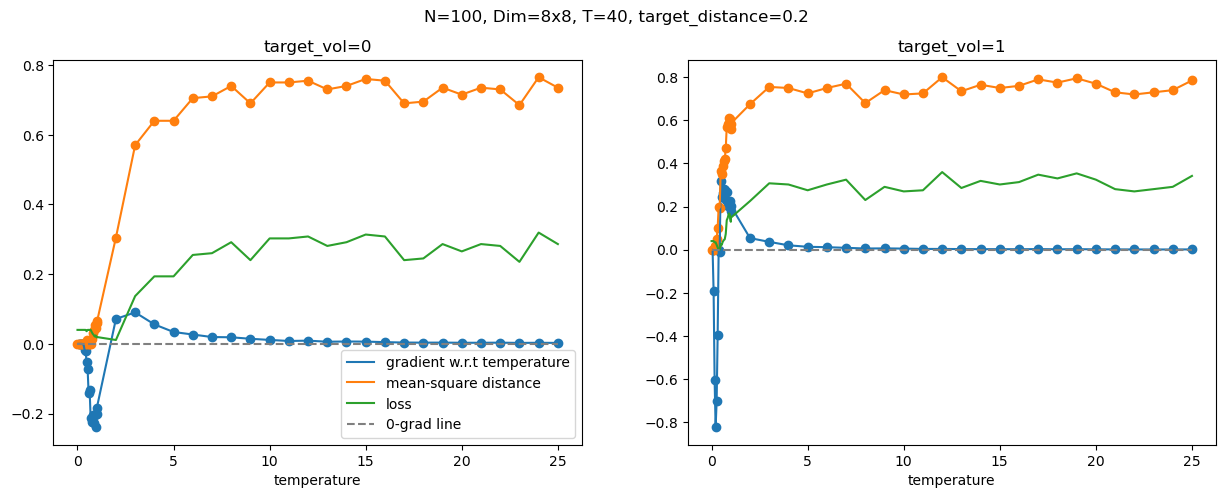

In [28]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.2")
plt.show()


target_vol = 0, target_dist = 0.4

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.4

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

target_vol = 1, target_distance = 0.4

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.4

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

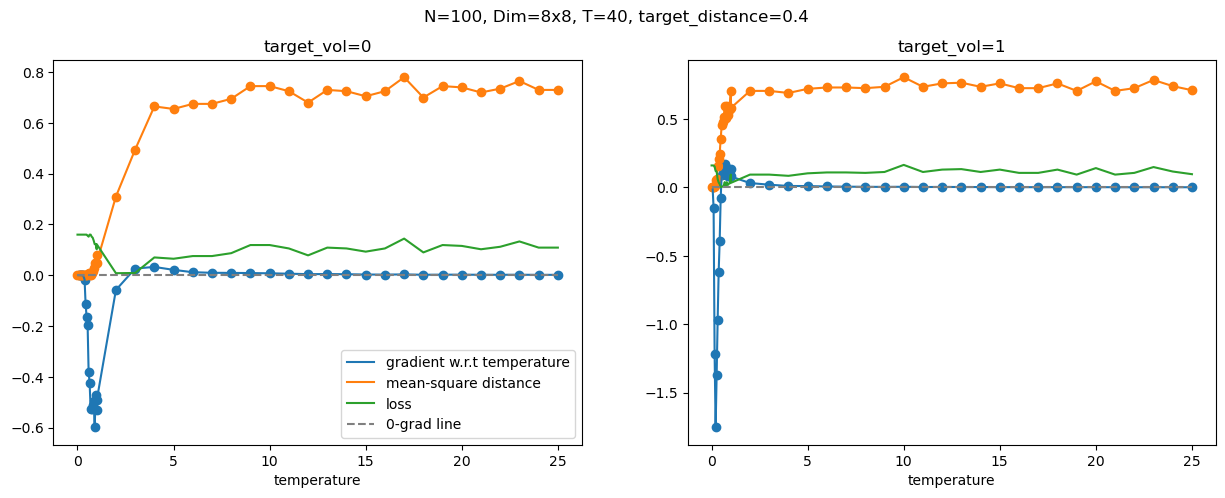

In [31]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(temps.cpu(), grads_v0)
axs[0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0].scatter(temps.cpu(), mean_distances_v0)
axs[0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0].plot(temps.cpu(), losses_v0, label="loss")
axs[0].set(title="target_vol=0", xlabel="temperature")
axs[0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[0].legend()

axs[1].scatter(temps.cpu(), grads_v1)
axs[1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1].scatter(temps.cpu(), mean_distances_v1)
axs[1].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1].plot(temps.cpu(), losses_v1, label="loss")
axs[1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1].set(title="target_vol=1", xlabel="temperature")

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.4")
plt.show()


target_vol = 0, target_dist = 0.6

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.6

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

target_vol = 1, target_dist = 0.6

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,8,8, device=device)
ref[:,4,4] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.6

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,8,8, device=device)
    batch[:,4,4] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=40, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())

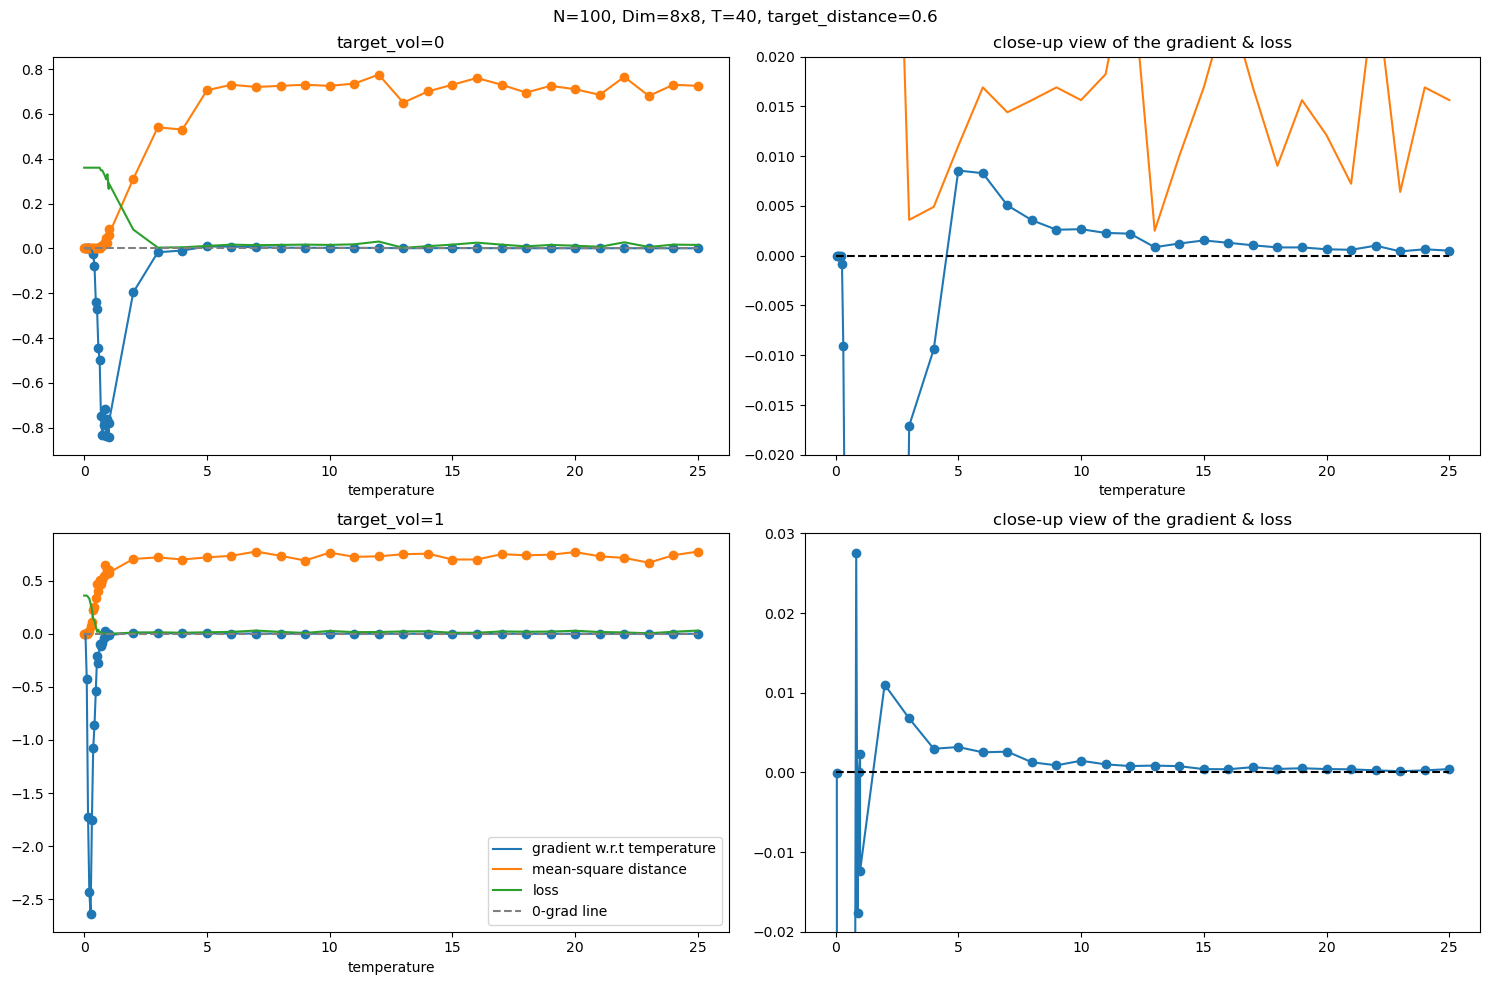

In [58]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].scatter(temps.cpu(), grads_v0)
axs[0,0].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0,0].scatter(temps.cpu(), mean_distances_v0)
axs[0,0].plot(temps.cpu(), mean_distances_v0, label="mean-square distance")
axs[0,0].plot(temps.cpu(), losses_v0, label="loss")
axs[0,0].set(title="target_vol=0", xlabel="temperature")
axs[0,0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")

axs[0,1].scatter(temps.cpu(), grads_v0)
axs[0,1].plot(temps.cpu(), grads_v0, label="gradient w.r.t temperature")
axs[0,1].plot(temps.cpu(), losses_v0)
axs[0,1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["black"], linestyles="dashed")
axs[0,1].set(title="close-up view of the gradient & loss", ylim=(-0.02,0.02), xlabel="temperature")

axs[1,0].scatter(temps.cpu(), grads_v1)
axs[1,0].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1,0].scatter(temps.cpu(), mean_distances_v1)
axs[1,0].plot(temps.cpu(), mean_distances_v1, label="mean-square distance")
axs[1,0].plot(temps.cpu(), losses_v1, label="loss")
axs[1,0].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["gray"], linestyles="dashed")
axs[1,0].set(title="target_vol=1", xlabel="temperature")
axs[1,0].legend()

axs[1,1].scatter(temps.cpu(), grads_v1)
axs[1,1].plot(temps.cpu(), grads_v1, label="gradient w.r.t temperature")
axs[1,1].hlines([0.], xmin=0, xmax=25, label="0-grad line", colors=["black"], linestyles="dashed")
axs[1,1].set(title="close-up view of the gradient & loss", ylim=(-0.02,0.03))

fig.suptitle("N=100, Dim=8x8, T=40, target_distance=0.6")
fig.tight_layout()
plt.show()


## Num_steps = 500, 256x256 grid

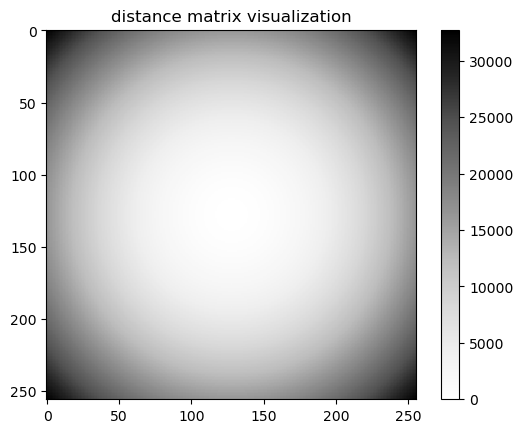

In [60]:
ref = t.zeros(1,256,256, device=device)
ref[:,128,128] += 1
dist_matrix = create_dist_matrix(ref)
fig = plt.imshow(dist_matrix.numpy(), cmap="Greys", interpolation="nearest", vmin=0, vmax=np.max(dist_matrix.numpy()))
plt.colorbar(fig)
plt.title("distance matrix visualization")
plt.show()

target_vol = 0, target_dist = 0

In [62]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 0.
ref = t.zeros(1,256,256, device=device)
ref[:,128,128] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v0 = []
mean_distances_v0 = []
losses_v0 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,256,256, device=device)
    batch[:,128,128] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=500, target_distance=target_distance)
    grads_v0.append(grad.detach().cpu().numpy())
    mean_distances_v0.append(mean_distance.detach().cpu().numpy())
    losses_v0.append(loss.detach().cpu().numpy())

100%|██████████| 500/500 [00:19<00:00, 25.77it/s]


temperature: 0.0, mean distance: 0.0
gradient: nan


100%|██████████| 500/500 [00:21<00:00, 22.89it/s]


temperature: 0.05263157933950424, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:28<00:00, 17.32it/s]


temperature: 0.10526315867900848, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:38<00:00, 13.01it/s]


temperature: 0.15789473056793213, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:28<00:00, 17.68it/s]


temperature: 0.21052631735801697, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:28<00:00, 17.78it/s]


temperature: 0.2631579041481018, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:35<00:00, 14.14it/s]


temperature: 0.31578946113586426, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]


temperature: 0.3684210479259491, mean distance: 0.010000000000000002
gradient: 0.006205829791724682


100%|██████████| 500/500 [00:31<00:00, 16.12it/s]


temperature: 0.42105263471603394, mean distance: 0.0
gradient: 0.0


100%|██████████| 500/500 [00:25<00:00, 19.63it/s]


temperature: 0.4736842215061188, mean distance: 0.010000000000000002
gradient: 0.0277959406375885


100%|██████████| 500/500 [00:36<00:00, 13.85it/s]


temperature: 0.5263158082962036, mean distance: 0.025000000000000005
gradient: 0.10774417221546173


100%|██████████| 500/500 [00:28<00:00, 17.58it/s]


temperature: 0.5789473652839661, mean distance: 0.03500000000000001
gradient: 0.1699220836162567


100%|██████████| 500/500 [00:36<00:00, 13.78it/s]


temperature: 0.6315789222717285, mean distance: 0.075
gradient: 0.34431442618370056


100%|██████████| 500/500 [00:28<00:00, 17.27it/s]


temperature: 0.6842105388641357, mean distance: 0.14500000000000002
gradient: 0.5979253649711609


100%|██████████| 500/500 [00:30<00:00, 16.35it/s]


temperature: 0.7368420958518982, mean distance: 0.185
gradient: 0.7109333276748657


100%|██████████| 500/500 [00:30<00:00, 16.30it/s]


temperature: 0.7894736528396606, mean distance: 0.21
gradient: 0.6806349754333496


100%|██████████| 500/500 [00:27<00:00, 18.03it/s]


temperature: 0.8421052694320679, mean distance: 0.245
gradient: 0.7251306176185608


100%|██████████| 500/500 [00:35<00:00, 14.21it/s]


temperature: 0.8947368264198303, mean distance: 0.375
gradient: 0.8540289998054504


100%|██████████| 500/500 [00:35<00:00, 13.92it/s]


temperature: 0.9473684430122375, mean distance: 0.37
gradient: 0.8315809369087219


100%|██████████| 500/500 [00:29<00:00, 17.11it/s]


temperature: 1.0, mean distance: 0.47
gradient: 0.8734839558601379


100%|██████████| 500/500 [00:23<00:00, 21.08it/s]


temperature: 1.0, mean distance: 0.46
gradient: 0.8638509511947632


100%|██████████| 500/500 [00:36<00:00, 13.55it/s]


temperature: 2.0, mean distance: 0.765
gradient: 0.2251504361629486


100%|██████████| 500/500 [00:31<00:00, 15.87it/s]


temperature: 3.0, mean distance: 0.725
gradient: 0.11395251750946045


100%|██████████| 500/500 [00:41<00:00, 12.11it/s]


temperature: 4.0, mean distance: 0.765
gradient: 0.06656765192747116


100%|██████████| 500/500 [00:35<00:00, 14.09it/s]


temperature: 5.0, mean distance: 0.78
gradient: 0.039428163319826126


100%|██████████| 500/500 [00:38<00:00, 12.98it/s]


temperature: 6.0, mean distance: 0.76
gradient: 0.032565779983997345


100%|██████████| 500/500 [00:38<00:00, 12.90it/s]


temperature: 7.0, mean distance: 0.735
gradient: 0.025669988244771957


100%|██████████| 500/500 [00:28<00:00, 17.45it/s]


temperature: 8.0, mean distance: 0.795
gradient: 0.018984079360961914


100%|██████████| 500/500 [00:32<00:00, 15.33it/s]


temperature: 9.0, mean distance: 0.72
gradient: 0.015162668190896511


100%|██████████| 500/500 [00:30<00:00, 16.61it/s]


temperature: 10.0, mean distance: 0.755
gradient: 0.015737388283014297


100%|██████████| 500/500 [00:19<00:00, 25.96it/s]


temperature: 11.0, mean distance: 0.725
gradient: 0.010736173950135708


100%|██████████| 500/500 [00:18<00:00, 26.39it/s]


temperature: 12.0, mean distance: 0.73
gradient: 0.010442357510328293


100%|██████████| 500/500 [00:18<00:00, 26.57it/s]


temperature: 13.0, mean distance: 0.78
gradient: 0.008754841983318329


100%|██████████| 500/500 [00:19<00:00, 26.25it/s]


temperature: 14.0, mean distance: 0.7
gradient: 0.007315525319427252


100%|██████████| 500/500 [00:18<00:00, 26.88it/s]


temperature: 15.0, mean distance: 0.81
gradient: 0.008179323747754097


100%|██████████| 500/500 [00:18<00:00, 26.66it/s]


temperature: 16.0, mean distance: 0.725
gradient: 0.006339521612972021


100%|██████████| 500/500 [00:18<00:00, 26.72it/s]


temperature: 17.0, mean distance: 0.74
gradient: 0.005205527413636446


100%|██████████| 500/500 [00:18<00:00, 26.64it/s]


temperature: 18.0, mean distance: 0.765
gradient: 0.005441139917820692


100%|██████████| 500/500 [00:18<00:00, 26.39it/s]


temperature: 19.0, mean distance: 0.77
gradient: 0.00529021630063653


100%|██████████| 500/500 [00:18<00:00, 26.82it/s]


temperature: 20.0, mean distance: 0.735
gradient: 0.004008286166936159


100%|██████████| 500/500 [00:18<00:00, 27.00it/s]


temperature: 21.0, mean distance: 0.8
gradient: 0.004600102547556162


100%|██████████| 500/500 [00:18<00:00, 26.90it/s]


temperature: 22.0, mean distance: 0.765
gradient: 0.0042938911356031895


100%|██████████| 500/500 [00:18<00:00, 26.69it/s]


temperature: 23.0, mean distance: 0.75
gradient: 0.0034172667656093836


100%|██████████| 500/500 [00:18<00:00, 26.73it/s]


temperature: 24.0, mean distance: 0.755
gradient: 0.00395599752664566


100%|██████████| 500/500 [00:18<00:00, 26.52it/s]


temperature: 25.0, mean distance: 0.765
gradient: 0.003250155597925186


target_vol = 1, target_dist = 0

In [ ]:
temps1 = t.linspace(0, 1, 20)
temps2 = t.linspace(1, 25, 25)
temps = t.concat((temps1, temps2))
target_vol = 1.
ref = t.zeros(1,256,256, device=device)
ref[:,128,128] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 0.

grads_v1 = []
mean_distances_v1 = []
losses_v1 = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(100,256,256, device=device)
    batch[:,128,128] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, target_vol, eta=1, num_steps=500, target_distance=target_distance)
    grads_v1.append(grad.detach().cpu().numpy())
    mean_distances_v1.append(mean_distance.detach().cpu().numpy())
    losses_v1.append(loss.detach().cpu().numpy())